## Imports

In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import ConcatDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import importlib

### Loading Repo

In [2]:
!git clone -b talib-1 http://github.com/Zapy67/ATML-PA-2

fatal: destination path 'ATML-PA-2' already exists and is not an empty directory.


In [37]:
!git pull http://github.com/Zapy67/ATML-PA-2 talib-1

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 374.05 KiB | 2.02 MiB/s, done.
From http://github.com/Zapy67/ATML-PA-2
 * branch            talib-1    -> FETCH_HEAD
Updating aa20299..70f903e
Fast-forward
 DANN & CDAN/DANN.py    |   2 +-
 DANN & CDAN/dann.ipynb | 370 +++++++++++++++++++++++++++++++++++++++----------
 2 files changed, 300 insertions(+), 72 deletions(-)


In [3]:
%cd ATML-PA-2/

/kaggle/working/ATML-PA-2


In [4]:
%cd "DANN & CDAN"

/kaggle/working/ATML-PA-2/DANN & CDAN


In [38]:
!ls

cdan.ipynb  CDAN.py  dann.ipynb  DANN.py  __pycache__  train.py  utils


In [6]:
from utils.dataset import MEAN, STD, OfficeHomeDataset
import utils
import os
from torchvision.models import ResNet50_Weights

importlib.reload(utils)

<module 'utils' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/__init__.py'>

### Loading Dataset

In [7]:
root_dir = '/kaggle/input/officehome/OfficeHomeDataset_10072016'
csv_file = '/kaggle/input/officehome/OfficeHomeDataset_10072016/ImageInfo.csv'

In [8]:
transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [9]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, target, transform)

(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                                link  
0  http://img03.deviantart.net/6533/i/2012/052/0/...  
1  http://img07.deviantart.net/a073/i/2011/214/5/...  
2  http://img08.deviantart.net/955f/i/2011/226/b/...  
3  http://img06.deviantart.net/d6fe/i/2006/177/7/...  
4  http://orig04.deviantart.net/7945/f/2013/237/b...  
(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                  

In [10]:
source_loader = DataLoader(source_ds, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_ds, batch_size=32, shuffle=True, num_workers=2)

In [20]:
def denormalize(img_tensor, mean=MEAN, std=STD):
    """Undo normalization on a single image tensor (C,H,W) → numpy (H,W,C) in [0,1]."""
    img = img_tensor.clone().cpu()
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    return img.numpy()

In [21]:
def show_images_from_dataset(dataset, n=8, title="Sample Images"):
    """
    Displays 'n' random images from the OfficeHomeDataset with class names.
    """
    plt.figure(figsize=(3 * n, 3))
    indices = torch.randperm(len(dataset))[:n]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img)
        label_name = list(dataset.class_to_idx.keys())[label]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label_name, fontsize=9)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


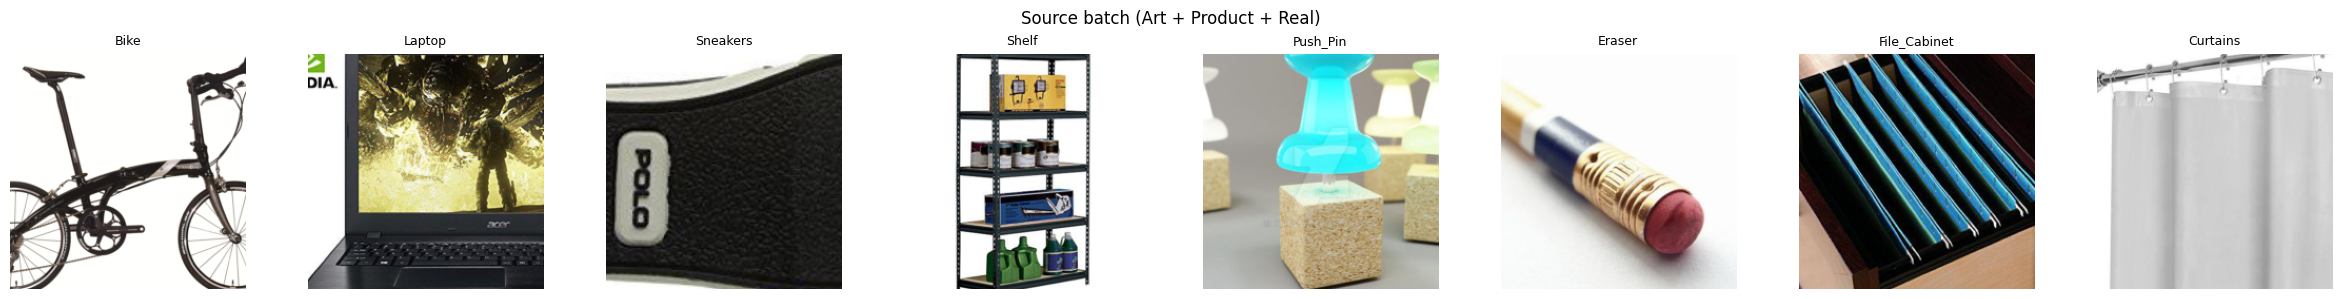

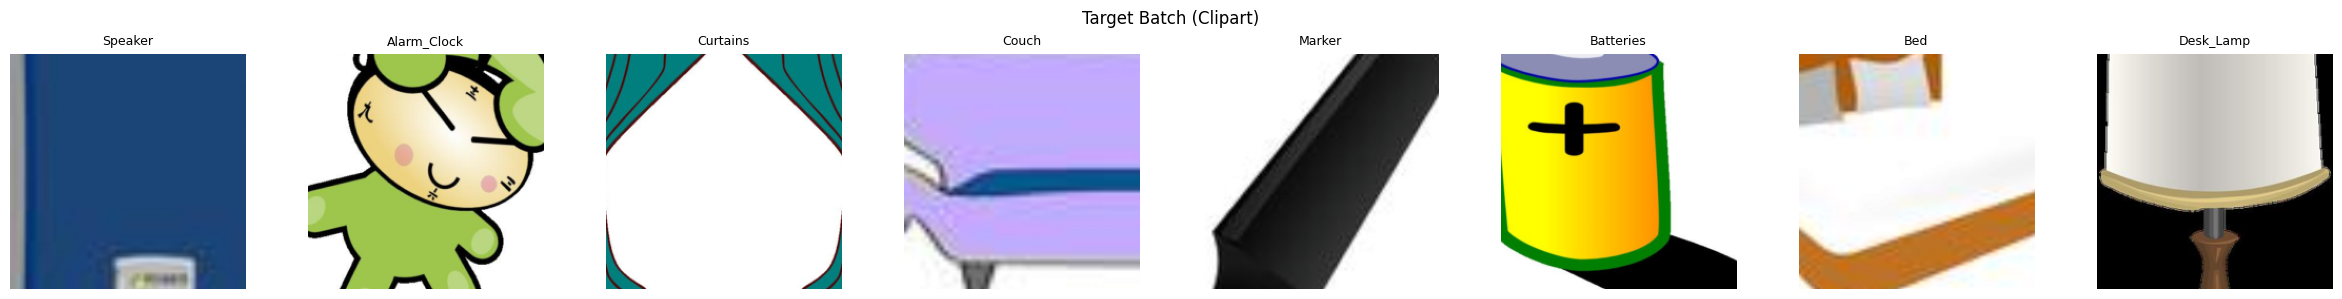

In [23]:
# show source images
show_images_from_dataset(source_ds, title="Source batch (Art + Product + Real)")
# show target images
show_images_from_dataset(target_ds, title="Target Batch (Clipart)")

## DANN Training

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
import DANN as dann
importlib.reload(dann)
importlib.reload(utils.dataset)

<module 'utils.dataset' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/dataset.py'>

In [13]:
from utils.dataset import FeatureTensorDataset
from torchvision.models import resnet50

In [14]:
import torch.nn as nn
class RestWrapper(nn.Module):
    """Wrap the `truncate_from(resnet, 'layer3')` module so it returns (B, D)
       and exposes output_dim attribute expected by DANN class."""
    def __init__(self, rest_module, output_dim=1024):
        super().__init__()
        self.rest = rest_module
        self.output_dim = output_dim

    def forward(self, featmap):
        out = self.rest(featmap)
        if out.dim() == 4:
            out = torch.flatten(out, 1)
        elif out.dim() == 2:
            # already flattened
            pass
        else:
            # keep guard
            out = out.view(out.size(0), -1)
        return out

In [15]:
def truncate_up_to(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        seq.add_module(name, module)
        if name == layer_name:
            break
    return seq

def truncate_from(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seen = False
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        if seen and name != 'fc':    # exclude final fc
            seq.add_module(name, module)
        if name == layer_name:
            seen = True
    return seq

def freeze_until(resnet: nn.Module, layer_name: str):
    freeze = True
    for name, module in resnet.named_children():
        if freeze:
            for p in module.parameters():
                p.requires_grad = False
        if name == layer_name:
            freeze = False

In [16]:
base_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
freeze_until(base_resnet, 'layer3')

In [17]:
cache_source = utils.dataset.FeatureTensorDataset(dataset=source_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)
cache_target = utils.dataset.FeatureTensorDataset(dataset=target_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)

Precomputing up to layer3: 100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


In [18]:
rest = truncate_from(base_resnet, 'layer3')
rest_wrapper = RestWrapper(rest, output_dim=2048).to(device)

In [41]:
model = dann.DANN(num_classes=65, resnet=rest_wrapper)

In [42]:
src_loader = DataLoader(cache_source, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
tgt_loader = DataLoader(cache_target, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [43]:
trainer = dann.DANNTrainer(
        model=model,
        device=device,
        learning_rate=1e-4,
        weight_decay=5e-4,
        gamma=5.0
    )

In [ ]:
trainer.train(source_loader=src_loader, target_loader=tgt_loader, num_epochs=10)

Epoch 1/20: 100%|██████████| 351/351 [00:38<00:00,  9.11it/s, cls_loss=1.0702, dom_loss=1.5149, cls_acc=1.0000, alpha=0.0000]
                                                                    

Epoch 1/20 - Train Loss: 3.7248, Train Acc: 0.7687, Target Loss: 2.5636, Target Acc: 0.4252


Epoch 2/20: 100%|██████████| 351/351 [00:38<00:00,  9.12it/s, cls_loss=0.4808, dom_loss=1.5956, cls_acc=1.0000, alpha=0.1244]
                                                                    

Epoch 2/20 - Train Loss: 1.9860, Train Acc: 0.9884, Target Loss: 2.3969, Target Acc: 0.4346


Epoch 3/20: 100%|██████████| 351/351 [00:38<00:00,  9.09it/s, cls_loss=0.0949, dom_loss=1.5560, cls_acc=1.0000, alpha=0.2449]
                                                                    

Epoch 3/20 - Train Loss: 1.6428, Train Acc: 0.9945, Target Loss: 2.4273, Target Acc: 0.4325


Epoch 4/20: 100%|██████████| 351/351 [00:38<00:00,  9.12it/s, cls_loss=0.1348, dom_loss=1.4234, cls_acc=1.0000, alpha=0.3584]
                                                                    

Epoch 4/20 - Train Loss: 1.5312, Train Acc: 0.9957, Target Loss: 2.4959, Target Acc: 0.4312


Epoch 5/20: 100%|██████████| 351/351 [00:38<00:00,  9.16it/s, cls_loss=0.0951, dom_loss=1.4217, cls_acc=1.0000, alpha=0.4621]
                                                                    

Epoch 5/20 - Train Loss: 1.4809, Train Acc: 0.9957, Target Loss: 2.5622, Target Acc: 0.4291


Epoch 6/20: 100%|██████████| 351/351 [00:38<00:00,  9.13it/s, cls_loss=0.1719, dom_loss=1.3535, cls_acc=0.9565, alpha=0.5546]
                                                                    

Epoch 6/20 - Train Loss: 1.4581, Train Acc: 0.9960, Target Loss: 2.6048, Target Acc: 0.4302


Epoch 7/20: 100%|██████████| 351/351 [00:38<00:00,  9.12it/s, cls_loss=0.0599, dom_loss=1.3712, cls_acc=1.0000, alpha=0.6351]
                                                                    

Epoch 7/20 - Train Loss: 1.4414, Train Acc: 0.9959, Target Loss: 2.6561, Target Acc: 0.4234


Epoch 8/20: 100%|██████████| 351/351 [00:38<00:00,  9.12it/s, cls_loss=0.0267, dom_loss=1.3869, cls_acc=1.0000, alpha=0.7039]
                                                                    

Epoch 8/20 - Train Loss: 1.4324, Train Acc: 0.9963, Target Loss: 2.6662, Target Acc: 0.4279


Epoch 9/20: 100%|██████████| 351/351 [00:38<00:00,  9.10it/s, cls_loss=0.0191, dom_loss=1.3754, cls_acc=1.0000, alpha=0.7616]
                                                                    

Epoch 9/20 - Train Loss: 1.4275, Train Acc: 0.9956, Target Loss: 2.7118, Target Acc: 0.4245


Epoch 10/20: 100%|██████████| 351/351 [00:38<00:00,  9.13it/s, cls_loss=0.0479, dom_loss=1.3912, cls_acc=1.0000, alpha=0.8093]
                                                                    

Epoch 10/20 - Train Loss: 1.4230, Train Acc: 0.9955, Target Loss: 2.7062, Target Acc: 0.4238


Epoch 11/20: 100%|██████████| 351/351 [00:38<00:00,  9.12it/s, cls_loss=0.0812, dom_loss=1.3983, cls_acc=1.0000, alpha=0.8483]
                                                                    

Epoch 11/20 - Train Loss: 1.4217, Train Acc: 0.9959, Target Loss: 2.7223, Target Acc: 0.4199


Epoch 12/20: 100%|██████████| 351/351 [00:38<00:00,  9.15it/s, cls_loss=0.0388, dom_loss=1.4057, cls_acc=1.0000, alpha=0.8798]
                                                                    

Epoch 12/20 - Train Loss: 1.4210, Train Acc: 0.9960, Target Loss: 2.7429, Target Acc: 0.4220


Epoch 13/20: 100%|██████████| 351/351 [00:38<00:00,  9.14it/s, cls_loss=0.0348, dom_loss=1.3828, cls_acc=1.0000, alpha=0.9051]
                                                                    

Epoch 13/20 - Train Loss: 1.4198, Train Acc: 0.9959, Target Loss: 2.7201, Target Acc: 0.4199


Epoch 14/20: 100%|██████████| 351/351 [00:38<00:00,  9.13it/s, cls_loss=0.0293, dom_loss=1.3858, cls_acc=1.0000, alpha=0.9253]
                                                                    

Epoch 14/20 - Train Loss: 1.4177, Train Acc: 0.9957, Target Loss: 2.7846, Target Acc: 0.4176


Epoch 15/20: 100%|██████████| 351/351 [00:38<00:00,  9.12it/s, cls_loss=0.0375, dom_loss=1.3916, cls_acc=1.0000, alpha=0.9414]
                                                                    

Epoch 15/20 - Train Loss: 1.4183, Train Acc: 0.9955, Target Loss: 2.7451, Target Acc: 0.4197


Epoch 16/20: 100%|██████████| 351/351 [00:38<00:00,  9.14it/s, cls_loss=0.0178, dom_loss=1.3905, cls_acc=1.0000, alpha=0.9540]
                                                                    

Epoch 16/20 - Train Loss: 1.4183, Train Acc: 0.9962, Target Loss: 2.6903, Target Acc: 0.4252



=== SOURCE REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.9119    0.9958    0.9520       239
    Backpack     0.8981    0.9958    0.9444       239
   Batteries     0.9745    1.0000    0.9871       153
         Bed     0.9880    0.9880    0.9880       166
        Bike     1.0000    0.9312    0.9644       218
      Bottle     0.9192    1.0000    0.9579       239
      Bucket     0.9938    0.9581    0.9756       167
  Calculator     0.9078    1.0000    0.9517       187
    Calendar     0.9882    0.9941    0.9912       169
     Candles     1.0000    0.9870    0.9935       231
       Chair     1.0000    0.9697    0.9846       264
  Clipboards     0.9682    0.9806    0.9744       155
    Computer     0.9403    0.9265    0.9333       204
       Couch     0.9758    0.9902    0.9830       204
    Curtains     1.0000    0.9947    0.9973       188
   Desk_Lamp     0.9937    0.9345    0.9632       168
       Drill     1.0000    0.9474    0.9730       133
    

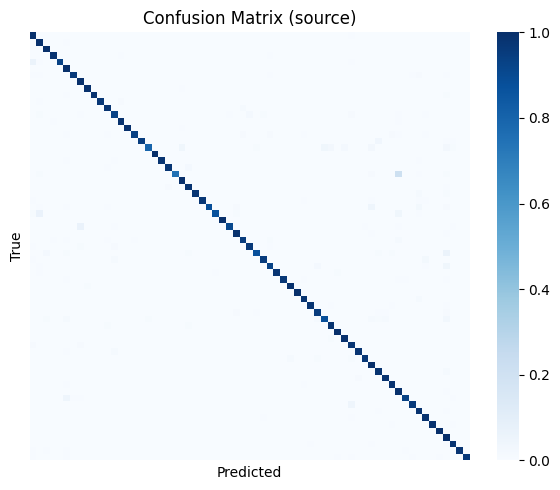

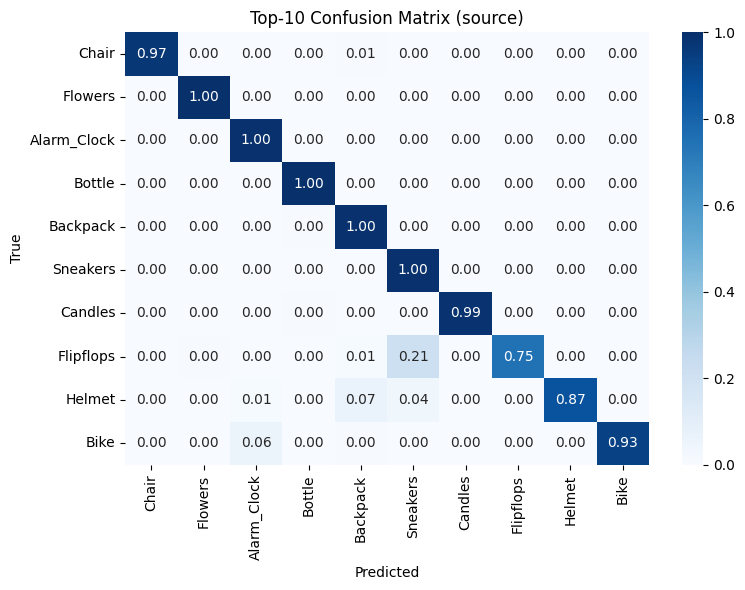


=== TARGET REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.4082    0.6667    0.5063        60
    Backpack     0.2703    0.3571    0.3077        56
   Batteries     0.6111    0.1719    0.2683        64
         Bed     0.8571    0.0612    0.1143        98
        Bike     0.9608    0.4949    0.6533        99
      Bottle     0.2604    0.2525    0.2564        99
      Bucket     0.4318    0.2603    0.3248        73
  Calculator     0.5362    0.8043    0.6435        46
    Calendar     0.4457    0.5256    0.4824        78
     Candles     0.6538    0.1717    0.2720        99
       Chair     0.4853    0.3333    0.3952        99
  Clipboards     0.1600    0.2000    0.1778        40
    Computer     0.1579    0.1818    0.1690        99
       Couch     0.3596    0.5000    0.4183        64
    Curtains     0.4694    0.5476    0.5055        42
   Desk_Lamp     0.2500    0.1220    0.1639        41
       Drill     0.8571    0.2500    0.3871        48
    

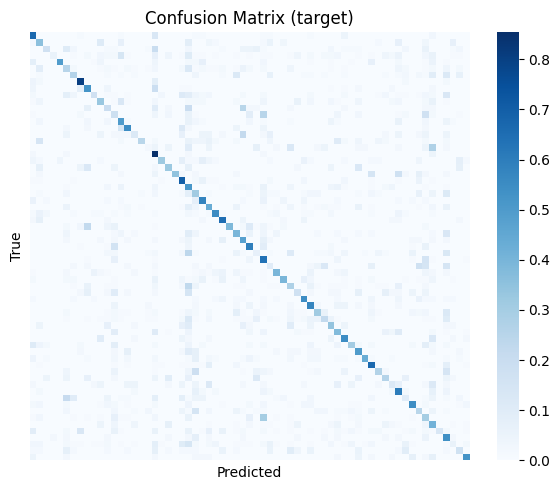

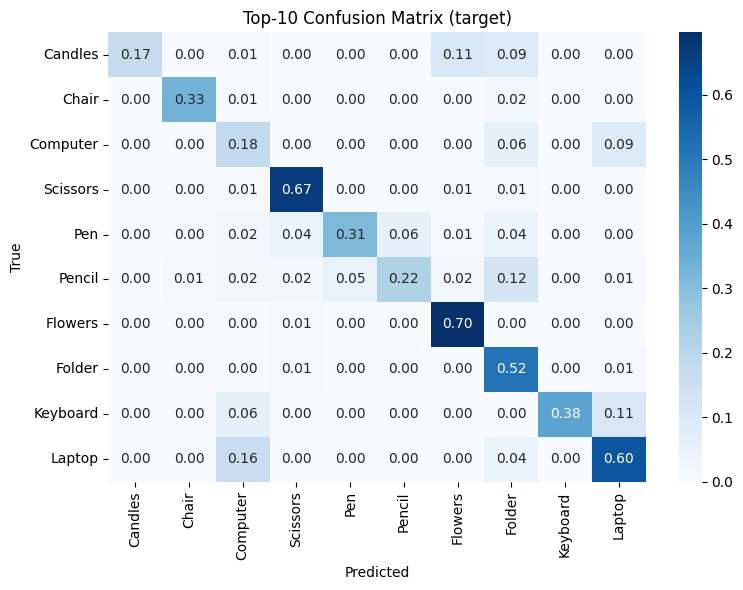

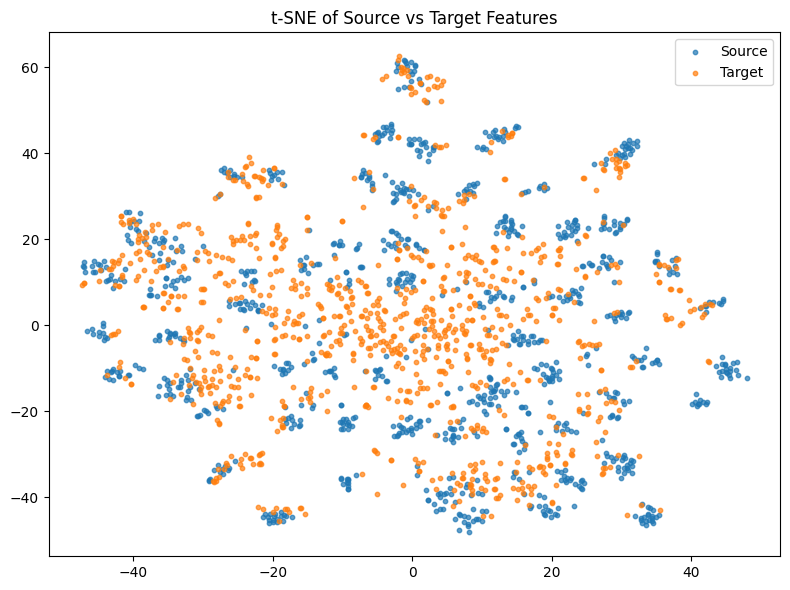

{'tsne': array([[ 14.267614 ,   6.532118 ],
        [ 12.449711 ,   7.7279453],
        [ 13.795635 ,  21.633205 ],
        ...,
        [-41.837486 ,  25.498596 ],
        [-19.657    ,   3.8685868],
        [ 28.32357  ,  39.92137  ]], dtype=float32),
 'source': {'report': '              precision    recall  f1-score   support\n\n Alarm_Clock     0.9119    0.9958    0.9520       239\n    Backpack     0.8981    0.9958    0.9444       239\n   Batteries     0.9745    1.0000    0.9871       153\n         Bed     0.9880    0.9880    0.9880       166\n        Bike     1.0000    0.9312    0.9644       218\n      Bottle     0.9192    1.0000    0.9579       239\n      Bucket     0.9938    0.9581    0.9756       167\n  Calculator     0.9078    1.0000    0.9517       187\n    Calendar     0.9882    0.9941    0.9912       169\n     Candles     1.0000    0.9870    0.9935       231\n       Chair     1.0000    0.9697    0.9846       264\n  Clipboards     0.9682    0.9806    0.9744       155\n    Co

In [ ]:
trainer.analysis(src_loader, tgt_loader, class_names= source_ds.classes,random_state=42)